# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

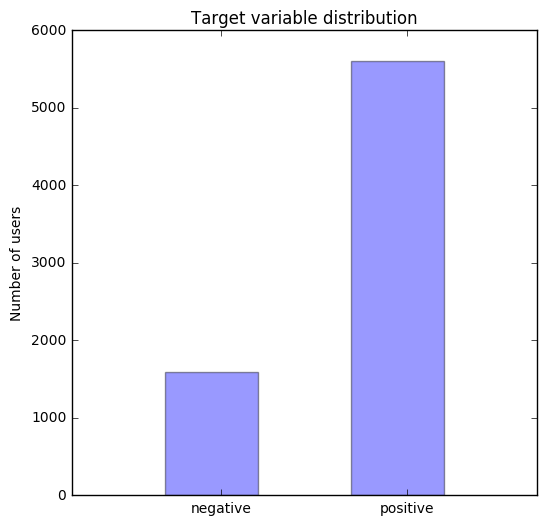

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = "uqVywMR4s7giRGSpKJrusINCx"
CONSUMER_SECRET = "KoXASo0HvMlgcGlpMA3pOkbVLedBsrRV1YHJS2SK1d4dgSGzje"

ACCESS_TOKEN_KEY = "778336064901672960-kbCJ3TJiIu3un9An8Kei0B0Zg9cb0aY"
ACCESS_TOKEN_SECRET = "0lCNlhF966Vu7swjMTg8TteOOpPJi41rP1hKXkuwoyf5z"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [15]:
import time
GEO_USER_NAME = "dorimer"
GEO_VERBOSE = False
location_cache = {}
def isgeolimit(rqjson):
    return ('status' in rqjson) and ('value' in rqjson['status']) and (int(rqjson['status']['value'])>10)
def get_coordinates_by_location(location):
    if location.lower() in location_cache:
        return location_cache[location.lower()]
    request_string = 'http://api.geonames.org/searchJSON?q="'+location+'"&maxRows=10&username='+GEO_USER_NAME
    result = (float('NaN'), float('NaN'), None)
    try:
        rq = requests.get(request_string)
        rqjson = rq.json()
        if isgeolimit(rqjson):
            if GEO_VERBOSE:
                print "Limit reached, waiting..."
            while isgeolimit(rqjson):
                time.sleep(60)
                rqjson = requests.get(request_string).json()
        if ('totalResultsCount' in rqjson) and (int(rqjson['totalResultsCount'])>0):
            geoname = rqjson['geonames'][0]
            if 'countryName' in geoname:
                result = (float(geoname['lat']),float(geoname['lng']),geoname['countryName'])
            else:
                if GEO_VERBOSE:
                    print 'Wrong location:', location
        else:
            if GEO_VERBOSE:
                print 'Wrong location:',location
                print rq.text
        location_cache[location.lower()] = result
        return result
    except KeyError:
        if GEO_VERBOSE:
            print "Request error:", request_string
            print rq.text


Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [22]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
users_file = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

def determine_processed(uidpart):
    for index,uid in enumerate(uidpart):
        if not (uid in processed_users):
            return uidpart[index:]
    return []
def get_user_records(df):
    LOOKUP_MAX = 100
    userlist = []
    uid_count=df['uid'].count()
    uidpart_index=0
    while uidpart_index*LOOKUP_MAX<uid_count:
        uidpart = list(df['uid'][uidpart_index*LOOKUP_MAX:(uidpart_index+1)*LOOKUP_MAX])
        if not (uidpart[-1] in processed_users):
            if uidpart[0] in processed_users:
                uidpart = determine_processed(uidpart)
            try:
                new_users = [twitter_user_to_dataframe_record(user) for user in api.UsersLookup(uidpart)]
            except IOError:
                users_file.close()
                raise
            userlist+=new_users
            for user in new_users:
                json.dump(user,users_file)
                users_file.write(u'\n')
        uidpart_index+=1
        print "Processed",uidpart_index*LOOKUP_MAX,"items\r"
    users_file.close()
    return userlist
print "Loaded", len(user_records), "items"
user_records += get_user_records(df_users)
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Loaded 11865 items
Processed 100 items
Processed 200 items
Processed 300 items
Processed 400 items
Processed 500 items
Processed 600 items
Processed 700 items
Processed 800 items
Processed 900 items
Processed 1000 items
Processed 1100 items
Processed 1200 items
Processed 1300 items
Processed 1400 items
Processed 1500 items
Processed 1600 items
Processed 1700 items
Processed 1800 items
Processed 1900 items
Processed 2000 items
Processed 2100 items
Processed 2200 items
Processed 2300 items
Processed 2400 items
Processed 2500 items
Processed 2600 items
Processed 2700 items
Processed 2800 items
Processed 2900 items
Processed 3000 items
Processed 3100 items
Processed 3200 items
Processed 3300 items
Processed 3400 items
Processed 3500 items
Processed 3600 items
Processed 3700 items
Processed 3800 items
Processed 3900 items
Processed 4000 items
Processed 4100 items
Processed 4200 items
Processed 4300 items
Processed 4400 items
Processed 4500 items
Processed 4600 items
Processed 4700 items
Pro

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

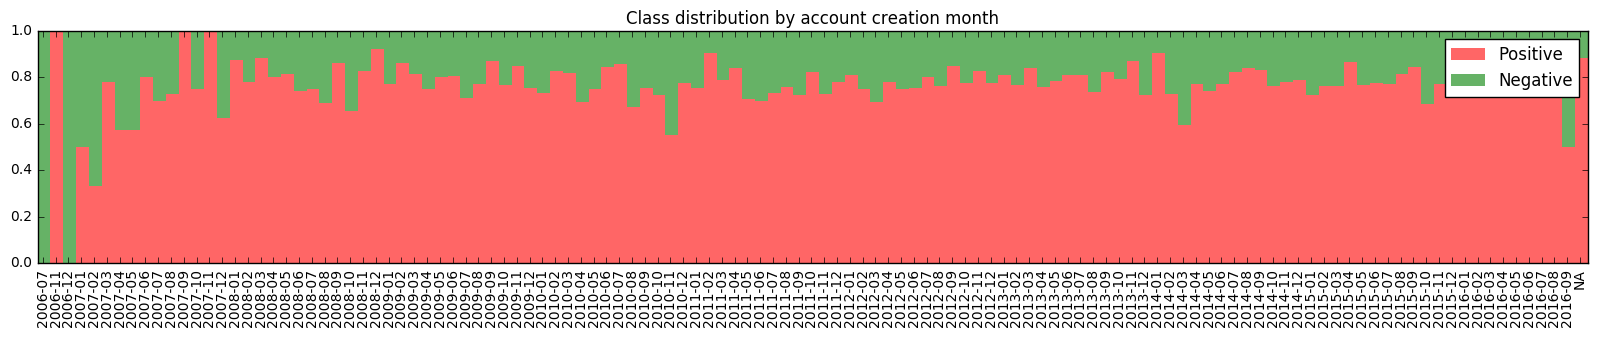

In [51]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = [data[0] for data in grouped]
    count_pos = np.array(grouped['cls'].sum())
    count_neg = np.array(grouped.count()['cls'])-count_pos
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

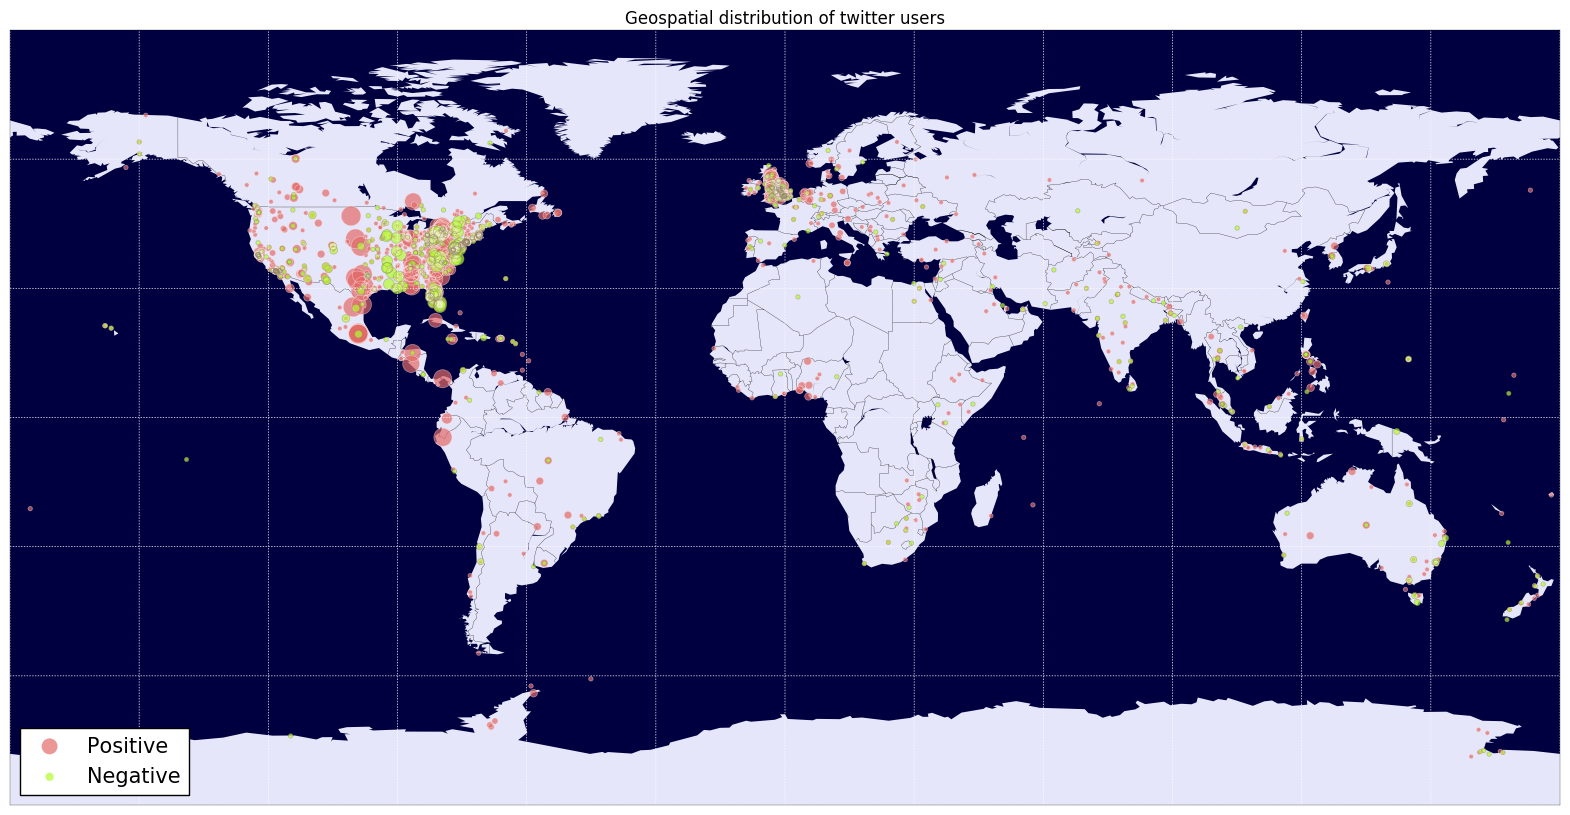

In [54]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    negpos_df = {'pos':df_full.loc[df_full['cls']>0.5], 'neg':df_full.loc[df_full['cls']<0.5]}
    grouped = {}
    count = {}
    size = {}
    pts = {}
    for k in ['pos','neg']:
        grouped[k] = negpos_df[k].groupby((negpos_df[k]['lon'],negpos_df[k]['lat']))
        count[k] = grouped[k].count()
        size[k] = count[k]*10
        pts[k] = np.array([data[0] for data in grouped[k]])
    pos_plot = m.scatter(pts['pos'][:,0], pts['pos'][:,1], s = size['pos'], marker = 'o', color = '#e26b69',edgecolor='none', zorder = 2, alpha = 0.7)
    neg_plot = m.scatter(pts['neg'][:,0], pts['neg'][:,1], s = size['neg'], marker = 'o', color = '#b3fc2d',edgecolor='none', zorder = 2, alpha = 0.7)
    pos_circ = m.scatter(pts['pos'][:,0], pts['pos'][:,1], s = size['pos'], marker = 'o',color = 'none',edgecolor='#fae9e8',linewidth=0.5, zorder = 3, alpha = 0.5)
    neg_circ = m.scatter(pts['neg'][:,0], pts['neg'][:,1], s = size['neg'], marker = 'o',color = 'none',edgecolor='#958464',linewidth=0.5, zorder = 3, alpha = 0.5)
    
    return pos_plot, neg_plot

pos,neg = plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend((pos, neg), ('Positive', 'Negative'), loc='lower left', scatterpoints = 1, fontsize = 15, markerscale = 0.5)
pl.show()


В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Площадь кругов зависит от количества пользователей, находящихся в этом месте
* Сами круги сделаны прозрачными, а по краям нанесены непрозрачные границы, которые, ко всему прочему, рисуются поверх всех кругов, таким образом мелкие круги более заметны под большими.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Ответы на вопросы:
   1. Потому что медиана не учитывает при подсчете количество подписчиков у каждого пользователя, по сути, все пользователи учитываются одинаково, тогда как на среднее арифметическое пользователи с большим количеством подписчиков оказывают большее влияние, таким образом, даже один очень популярный пользователь может существенно изменить значение mean. Это можно наблюдать, посмотрев на гистограмму и увидев, что пользователей с небольшим числом подписчиков гораздо больше остальных, однако mean находится гораздо дальше median, то есть количество подписчиков в среднем сильно больше, чем количество подписчиков у наименее популярных 50% пользователей.
   2. И mean и median больше у негативного класса. Если на mean могли повлиять несколько очень популярных аккаунтов, то median от этого не зависит. Поэтому, пользователи негативного класса, хоть и не намного, но популярнее.

Positive followers_count stats:
    Min: 0
    Max: 578217
    Mean: 2619.928
    Median: 350.5
Negative followers_count stats:
    Min: 0
    Max: 590481
    Mean: 3095.265
    Median: 372.0


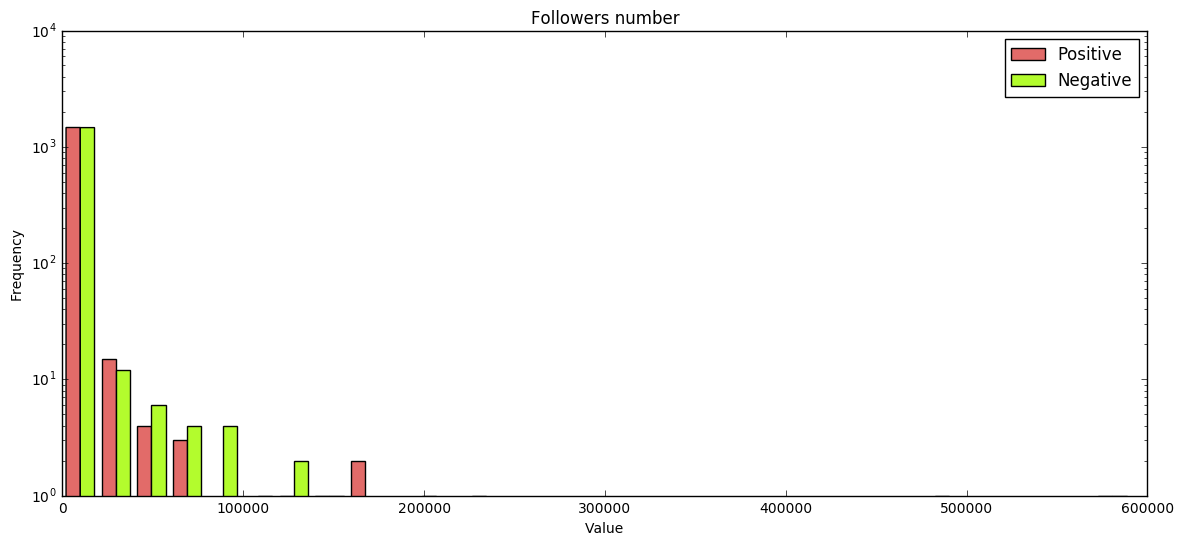

In [66]:
sample_number = 1500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    users = {'neg':users_wth_neg_class['followers_count'],
             'pos':users_wth_pos_class['followers_count']}
    for k in ['pos','neg']:
        print 'Positive' if k=='pos' else 'Negative', 'followers_count stats:'
        print '    Min: %.0f' % users[k].min()
        print '    Max: %.0f' % users[k].max()
        print '    Mean: %.3f' % users[k].mean()
        print '    Median: %.1f' % users[k].median()
    minmax = (min(users['neg'].min(),users['pos'].min()),max(users['neg'].max(),users['pos'].max()))
    fig = plt.figure(figsize=(14,6))
    n, bins, patches = plt.hist([list(users['pos']),list(users['neg'])],range=minmax,histtype='bar',log=True,
                               label=['Positive', 'Negative'],color=['#e26b69','#b3fc2d'],bins=30)
    pl.xlabel("Value")
    pl.ylabel("Frequency")
    pl.title("Followers number")
    plt.legend()
    
    
descriptive_stat_and_hist(users_wth_neg_class,users_wth_pos_class)


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [50]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1054.0,1962.0,9482.0,21338.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1196.0,837.0,19299.0,7184.0,110.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,577.0,7852.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,None,2013-06,2375.0,2436.0,187957.0,88148.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,NaN,NaN,None,2015-12,1246.0,970.0,36908.0,27048.0,75.0
